# 1. Distribución anual de Vuelos Totales, Retrasados y Cancelados. Valores medios, máximos y mínimos.

## 1.1 Importación de librerías necesarias

Inicialmente se cargan las librerías de python necesarias.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

sns.set_style("darkgrid")

## 1.2 Conexión con MONGO ATLAS / LOCAL

In [2]:
#Mongo Atlas
#URI ="mongodb://sato:<PASSWORD>@satoclusterfaa-shard-00-00-gst6h.\
#azure.mongodb.net:27017,satoclusterfaa-shard-00-01-gst6h.azure.\
#mongodb.net:27017,satoclusterfaa-shard-00-02-gst6h.azure.mongodb\
#.net:27017/test?ssl=true&replicaSet=SatoClusterFAA-shard-0&authSource=admin&retryWrites=true"

#client = MongoClient(URI)
#db = client.FAA_Airlines

#local
client = MongoClient()#"mongodb://localhost:27017")
db = client.airports

Se crea la variable **air** para facilitar las consultas

In [3]:
air = db.airlines

## 1.3 Distribución anuales.

Con este consulta se pretende obtener la **distibución anual** de:

- **Vuelos Totales**
- **Vuelos Retrasados**
- **Vuelos Cancelados** 

Los pasos a seguir son los siguientes.

1. Se seleccionan los años que sean distintos a 2003 y 2016.
2. Se agrupa por año y se calcula la suma total de los Vuelos Totales, Vuelos Retrasados y Vuelos Cancelados.

- **Query 1**

In [4]:
pipeline1 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$time.year", 
                        "Totales": {"$sum": "$statistics.flights.total"},
                        "Retrasados": {"$sum": "$statistics.flights.delayed"},
                        "Cancelados": {"$sum": "$statistics.flights.cancelled"}
                        }
             }    
            ]
curs1 = air.aggregate(pipeline1)

Con el cursor obtenido de la consulta, se crea un **DataFrame** con los resultados de la misma.

In [5]:
query1 = list(curs1)

In [6]:
df = pd.DataFrame(query1).set_index(['_id']).sort_index()
df

,Cancelados,Retrasados,Totales
_id,,,
2004.0,77940.0,880677.0,4344735.0
2005.0,83188.0,925578.0,4373522.0
2006.0,78475.0,1024612.0,4437952.0
2007.0,102665.0,1129439.0,4538488.0
2008.0,87650.0,965136.0,4307649.0
2009.0,58341.0,787472.0,4038900.0
2010.0,75018.0,732445.0,4050772.0
2011.0,77467.0,715560.0,3923295.0
2012.0,53494.0,658326.0,3955389.0


A partir de lo anterior y con las siguientes consultas se pretende obtener los **valores medios, máximos y mínimos** de los **Vuelos Totales, Vuelos Retrasados y Vuelos Cancelados** durante el período de estudio. Los pasos a seguir son los siguientes.

1. Se seleccionan los años que sean distintos a 2003 y 2016.
2. Se agrupa por año y se calcula la **suma total de los Vuelos Totales, Vuelos Retrasados y Vuelos Cancelados**.

Con la siguiente query se genera la nueva colección **Indicadores_Anuales** que se guarda en la colección **Indicadores_Anuales**.

In [7]:
pipeline1a = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$time.year", 
                        "Totales": {"$sum": "$statistics.flights.total"},
                        "Retrasados": {"$sum": "$statistics.flights.delayed"},
                        "Cancelados": {"$sum": "$statistics.flights.cancelled"}
                        }
             },
             {"$out": "Indicadores_Anuales"}              
            ]
air.aggregate(pipeline1a);

In [8]:
indicadores = db.Indicadores_Anuales

- **Query 2. Valores medios** 

Con la siguiente consulta sobre la **nueva colección Indicadores_Anuales** se obtiene las medias.

In [9]:
curs2 = indicadores.aggregate([{"$group": {"_id": "null",
                             "Media_Ind_Retrasados": {"$avg": "$Retrasados"},
                             "Media_Ind_Cancelados": {"$avg": "$Cancelados"},
                             "Media_Ind_Totales": {"$avg": "$Totales"}                       
                             }
                           },
                          {"$project": {"_id": 0}}
                         ]
                        )

In [10]:
Medias_Ind =list(curs2)[0]
Medias_Ind

{'Media_Ind_Retrasados': 844035.1666666666,
 'Media_Ind_Cancelados': 74830.83333333333,
 'Media_Ind_Totales': 4147835.6666666665}

Para calcular los **años donde los vuelos retrasados son mayores a la media**

In [11]:
year_media_Retrasados = indicadores.find({"Retrasados": 
                                       {"$gt": Medias_Ind["Media_Ind_Retrasados"]}}, {"_id": 1})

In [12]:
year_media_Retrasados = list(year_media_Retrasados)
year_media_Retrasados

[{'_id': 2007.0},
 {'_id': 2005.0},
 {'_id': 2004.0},
 {'_id': 2006.0},
 {'_id': 2008.0}]

Para calcular los **años donde los vuelos cancelados son mayores a la media**

In [13]:
year_media_Cancelados = indicadores.find({"Cancelados": 
                                         {"$gt": Medias_Ind["Media_Ind_Cancelados"]}}, {"_id": 1})

In [14]:
year_media_Cancelados = list(year_media_Cancelados)
year_media_Cancelados

[{'_id': 2014.0},
 {'_id': 2007.0},
 {'_id': 2005.0},
 {'_id': 2004.0},
 {'_id': 2010.0},
 {'_id': 2006.0},
 {'_id': 2011.0},
 {'_id': 2008.0}]

Para calcular los **años donde los vuelos totales son mayores a la media**

In [15]:
year_media_Totales = indicadores.find({"Totales": 
                                      {"$gt": Medias_Ind["Media_Ind_Totales"]}}, {"_id": 1})

In [16]:
year_media_Totales = list(year_media_Totales)
year_media_Totales

[{'_id': 2007.0},
 {'_id': 2005.0},
 {'_id': 2004.0},
 {'_id': 2006.0},
 {'_id': 2008.0}]

- **Query 3. Valores máximos**

Con la siguiente consulta sobre la **nueva colección Indicadores_Anuales** se obtiene los máximos.

In [17]:
curs3 = indicadores.aggregate([{"$group": {"_id": "null",
                             "Max_Ind_Retrasados": {"$max": "$Retrasados"},
                             "Max_Ind_Cancelados": {"$max": "$Cancelados"},
                             "Max_Ind_Totales": {"$max": "$Totales"}                       
                             }
                           },
                          {"$project": {"_id": 0}}
                         ]
                        )

In [18]:
Max_Ind =list(curs3)[0]
Max_Ind

{'Max_Ind_Retrasados': 1129439.0,
 'Max_Ind_Cancelados': 102665.0,
 'Max_Ind_Totales': 4538488.0}

Para calcular el **año donde se produce el máximo de los vuelos retrasados**

In [19]:
year_max_Retrasados = indicadores.find({"Retrasados": Max_Ind["Max_Ind_Retrasados"]}, {"_id": 1})

In [20]:
year_max_Retrasados = list(year_max_Retrasados)
year_max_Retrasados

[{'_id': 2007.0}]

Para calcular el **año donde se produce el máximo de los vuelos Cancelados**

In [21]:
year_max_Cancelados = indicadores.find({"Cancelados": Max_Ind["Max_Ind_Cancelados"]}, {"_id": 1})

In [22]:
year_max_Cancelados = list(year_max_Cancelados)
year_max_Cancelados

[{'_id': 2007.0}]

Para calcular el **año donde se produce el máximo de los vuelos Totales**

In [23]:
year_max_Totales = indicadores.find({"Totales": Max_Ind["Max_Ind_Totales"]}, {"_id": 1})

In [24]:
year_max_Totales = list(year_max_Totales)
year_max_Totales

[{'_id': 2007.0}]

- **Query 4. Valores mínimos**

Con la siguiente consulta sobre la **nueva colección Indicadores_Anuales** se obtiene los mínimos.

In [25]:
curs4 = indicadores.aggregate([{"$group": {"_id": "null",
                             "Min_Ind_Retrasados": {"$min": "$Retrasados"},
                             "Min_Ind_Cancelados": {"$min": "$Cancelados"},
                             "Min_Ind_Totales": {"$min": "$Totales"}                       
                             }
                           },
                          {"$project": {"_id": 0}}
                         ]
                        )
Min_Ind =list(curs4)[0]
Min_Ind

{'Min_Ind_Retrasados': 658326.0,
 'Min_Ind_Cancelados': 53494.0,
 'Min_Ind_Totales': 3824651.0}

Para calcular el **año donde se produce el mínimo de los vuelos retrasados**

In [26]:
year_min_Retrasados = indicadores.find({"Retrasados": Min_Ind["Min_Ind_Retrasados"]}, {"_id": 1})

In [27]:
year_min_Retrasados = list(year_min_Retrasados)
year_min_Retrasados

[{'_id': 2012.0}]

Para calcular el **año donde se produce el mínimo de los vuelos Cancelados**

In [28]:
year_min_Cancelados = indicadores.find({"Cancelados": Min_Ind["Min_Ind_Cancelados"]}, {"_id": 1})

In [29]:
year_min_Cancelados = list(year_min_Cancelados)
year_min_Cancelados

[{'_id': 2012.0}]

Para calcular el **año donde se produce el mín de los vuelos Totales**

In [30]:
year_min_Totales = indicadores.find({"Totales": Min_Ind["Min_Ind_Totales"]}, {"_id": 1})

In [31]:
year_min_Totales = list(year_min_Totales)
year_min_Totales

[{'_id': 2014.0}]

Finalmente, y para corroborar los resultados anteriores, se crean los gráficos correspondientes a las evoluciones:
- **Vuelos Cancelados**
- **Vuelos Retrasados**
- **Vuelos Totales**

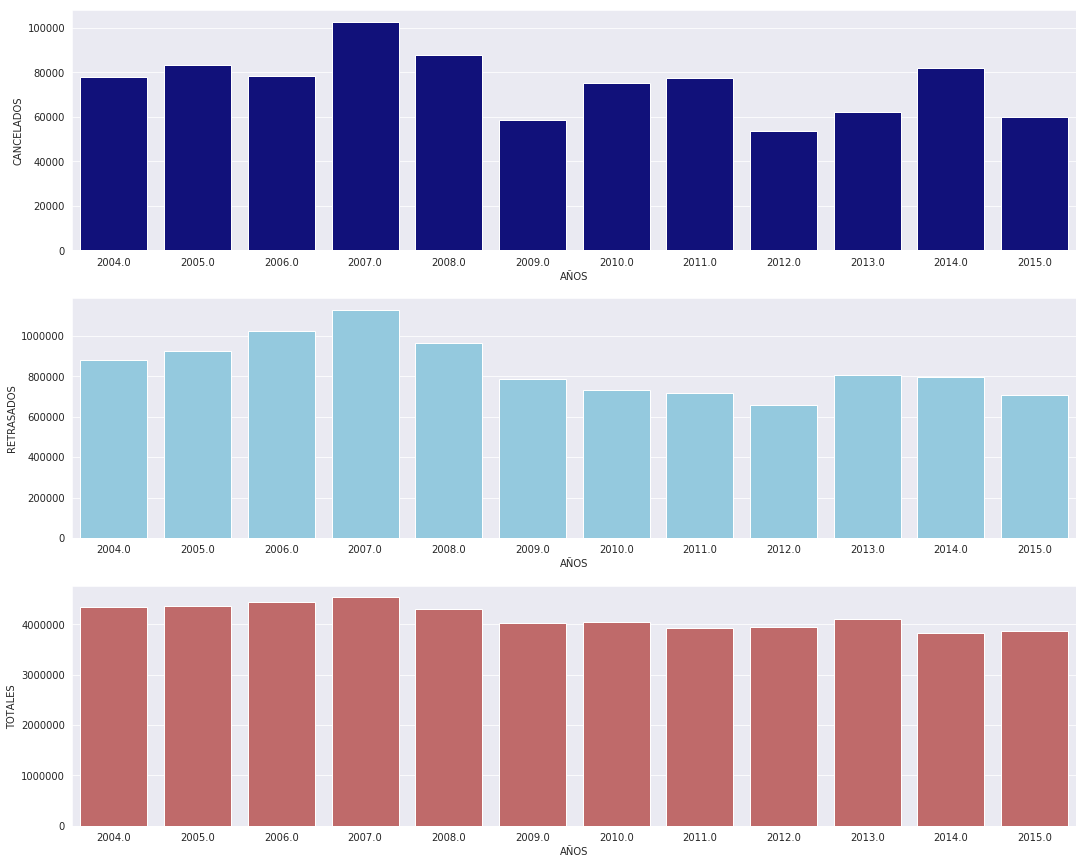

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15));

sns.barplot(x=df.index, y= df.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("CANCELADOS");
ax1.set_xlabel("AÑOS");

sns.barplot(x=df.index, y= df.iloc[:,1], color= 'SkyBlue', ax=ax2);
ax2.set_ylabel("RETRASADOS");
ax2.set_xlabel("AÑOS");

sns.barplot(x=df.index, y= df.iloc[:,2], color= 'IndianRed', ax=ax3);
ax3.set_ylabel("TOTALES");
ax3.set_xlabel("AÑOS");

## 2. Relación entre Vuelos Totales y Retrasados, Vuelos Totales y Cancelados y Vuelos Totales y Cancelados. 

De la **Query 1**, se toman los valore de los vuelos totales, retrasados y cancelados y se analiza la posible correlación entre ellas. Se busca una posible relación lineal. 

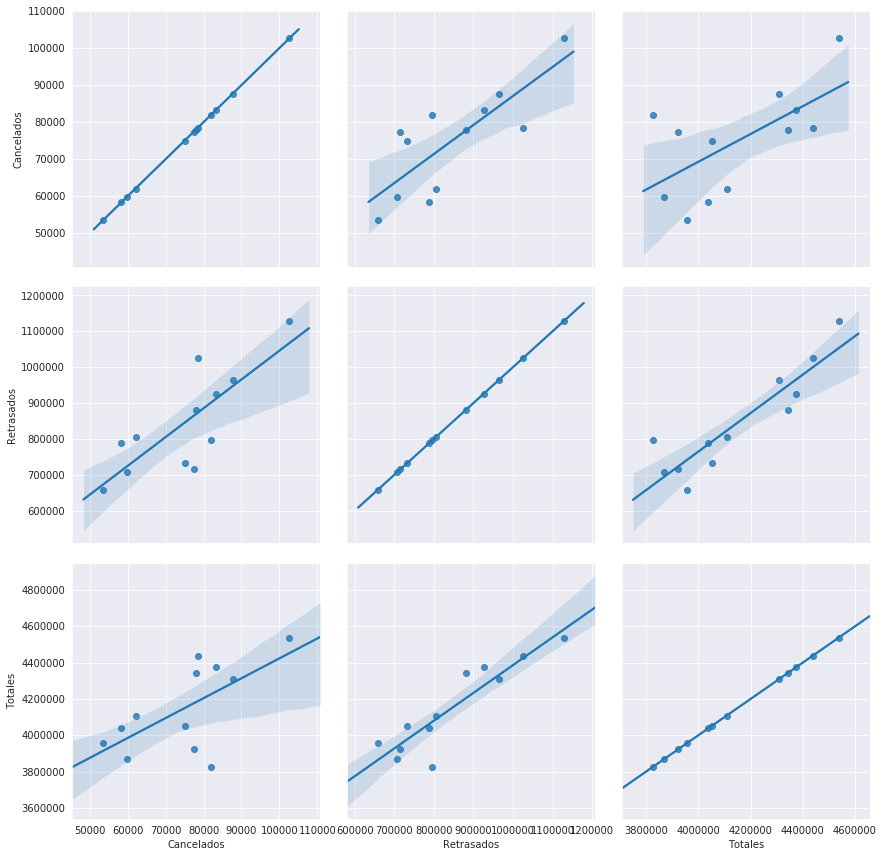

In [41]:
g = sns.PairGrid(df, height= 4);
g.map(sns.regplot);

Con los gráficos anteriores se pone de manifiesto la **correlación (positiva)** existente entre:

- Vuelos Totales y Cancelados
- Vuelos Totales y Retrasados
- Vuelos Cancelados y Retrasados

Es decir, **a mayor volumen de tráfico mayor número en los retrasos y cancelaciones. Además, a mayor número de retrasos mayor número de cancelaciones**. 


## 3. Evolución mensual entre 2014-2015 de los Minutos de retraso, Ratio de vuelos cancelados, Ratio de vuelos retrasados y vuelos totales

En este apartado, se analiza la **evolución mensual de dichos indicadores durante los años 2014-2015. Se diseña la siguiente consulta**:

- se filtra los años de estudio 
- se calculan los indicadores 

In [34]:
curs5 = air.aggregate([{"$match": {"time.year": {"$in": [2014, 2015]}}
              },
              {"$group": {"_id": {"Year": "$time.year",
                                  "Month": "$time.month"},
                         "minTotales": {"$sum": "$statistics.minutes delayed.total"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"}
                        }
              },
              {"$project": {"Year": "$_id.Year",
                            "Month": "$_id.Month",
                            "minTotales": "$minTotales",
                            "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                            "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                            "Vuelos_Totales": "$Totales",
                            "_id": 0
                           }
              },
              {"$sort": {"Year": 1, "Month": 1}}
            ]
)

In [35]:
query5 = list(curs5)

In [36]:
df2 = pd.DataFrame(query5).set_index(["Year", "Month"])

Se crea el gráfico que nos da la **evolución de Vuelos Totales**

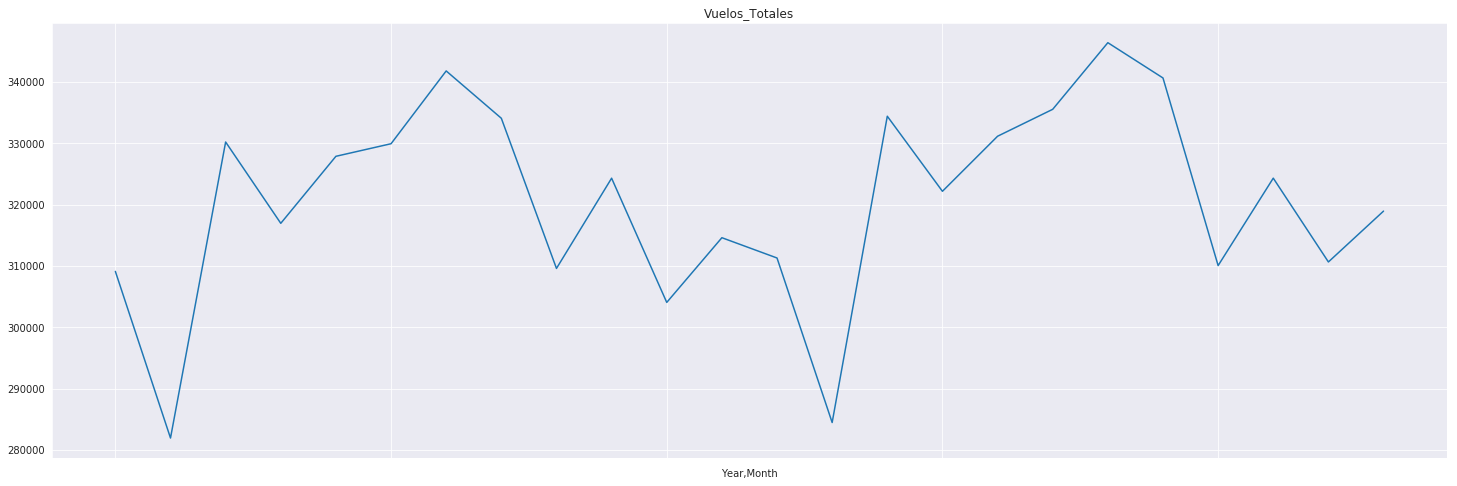

In [37]:
df2["Vuelos_Totales"].plot(kind= "line", figsize=(25,8), title = "Vuelos_Totales");

Se crea el gráfico que nos da la **evolución de los Minutos Totales**

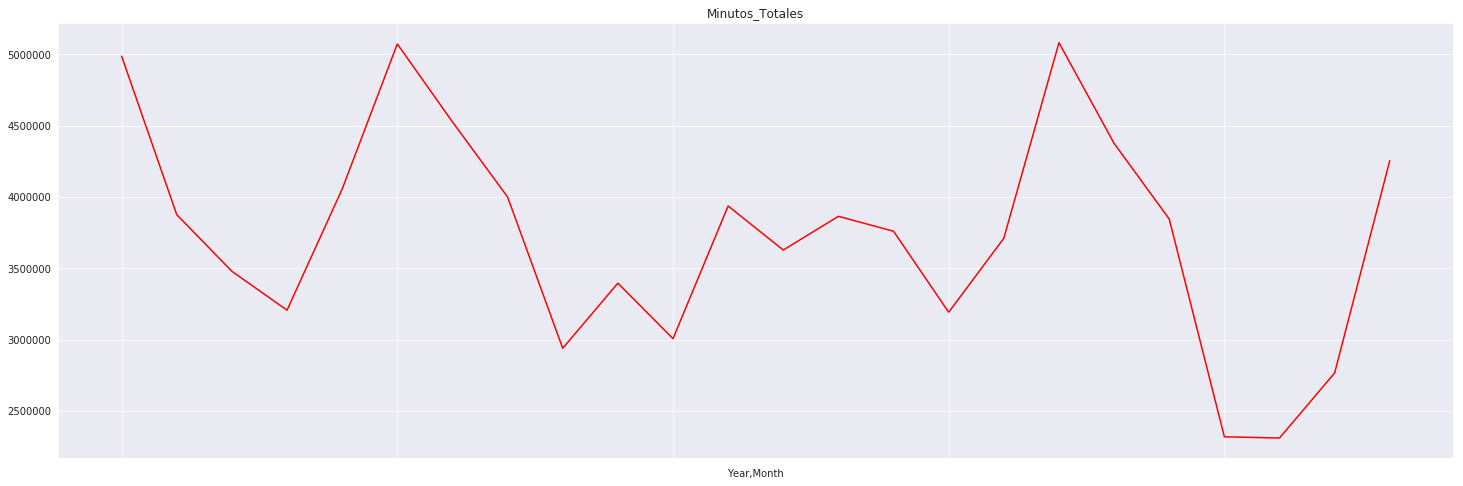

In [38]:
df2["minTotales"].plot(kind= "line", figsize=(25,8), title = "Minutos_Totales", color = "red");

Se crea el gráfico que nos da la **evolución del Ratio Retrasado** 

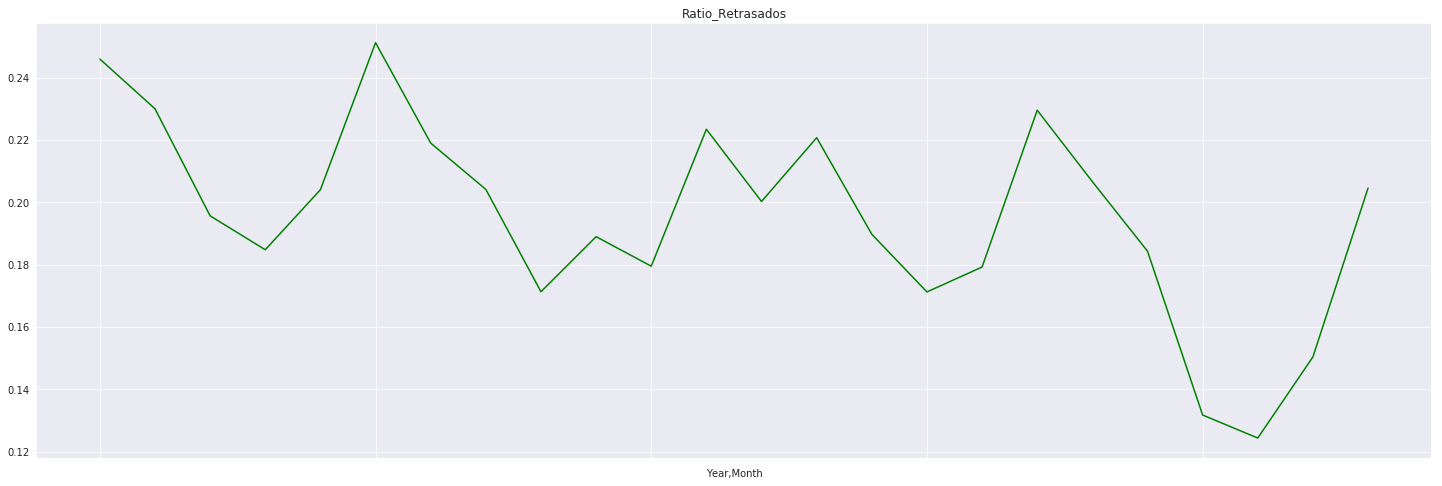

In [39]:
df2["Ratio_Retrasados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Retrasados", color = "green");

Se crea el gráfico que nos da la **evolución del Ratio Cancelados**

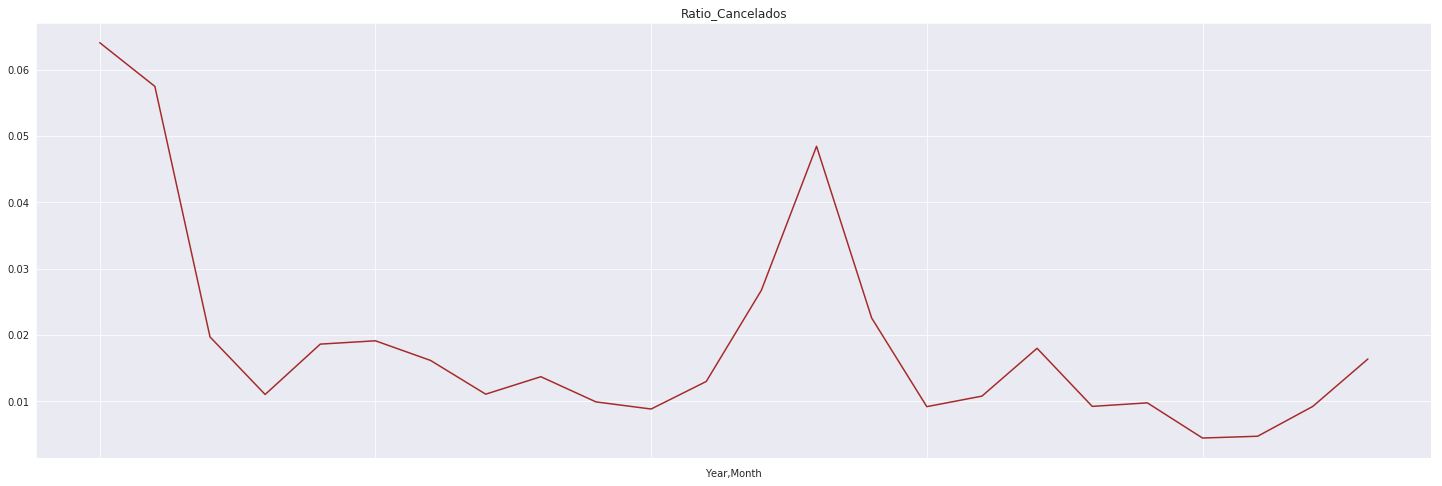

In [40]:
df2["Ratio_Cancelados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Cancelados", color = "brown");